In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
import utils
df_raw = pd.read_csv('data/summary_listings.csv', low_memory=False, dtype=utils.schema)
df_raw.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [3]:
TARGET = 'price'

# data summary

In [4]:
print("It contains {} rows and {} columns.".format(*df_raw.shape))
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))
print("It contains {} missing target.".format(df_raw[TARGET].isna().sum()))

It contains 51887 rows and 16 columns.
It contains 1869 duplicates.
It contains 0 missing target.


In [5]:
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.499297
Private room       0.347987
Shared room        0.080791
Hotel room         0.071926
Name: room_type, dtype: float64

In [6]:
df_raw[TARGET].describe()

count     51887.000000
mean       2505.201746
std        8852.372378
min           0.000000
25%         950.000000
50%        1494.000000
75%        2452.000000
max      300255.000000
Name: price, dtype: float64

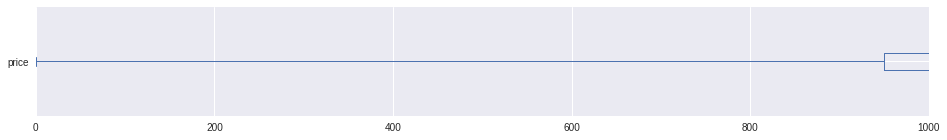

In [7]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw[TARGET].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2));

# Imputing Data

In [8]:
df_raw.isna().sum()

id                                    0
name                                 17
host_id                               0
host_name                            22
neighbourhood_group               51887
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       12135
reviews_per_month                 12135
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [9]:
df_train = df_raw.drop(columns=['neighbourhood_group', 'name', 'host_name', 'last_review'])
df_train.reviews_per_month.fillna(value=0, inplace=True)
df_train['neighbourhood'] = df_train.neighbourhood.astype('category')
df_train['room_type'] = df_train.room_type.astype('category')
df_target = df_train[[TARGET]]
df_train.drop(columns=[TARGET], inplace=True)
df_train.dtypes

id                                   int64
host_id                              int64
neighbourhood                     category
latitude                           float64
longitude                          float64
room_type                         category
minimum_nights                       int64
number_of_reviews                    int64
reviews_per_month                  float64
calculated_host_listings_count       int64
availability_365                     int64
dtype: object

In [10]:
# one-hot encoding of categorical features
cat_feats = df_train.select_dtypes(include=['category']).copy()
cat_feats_original_names = cat_feats.columns
cat_feats = pd.get_dummies(cat_feats)
df_train_encoded = pd.concat([df_train, cat_feats], axis=1)
df_train_encoded.drop(columns=cat_feats_original_names, inplace=True)
df_train_encoded

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_中山區,...,neighbourhood_士林區,neighbourhood_大同區,neighbourhood_大安區,neighbourhood_文山區,neighbourhood_松山區,neighbourhood_萬華區,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,74641,393116,25.05159,121.54747,3,49,0.47,4,88,0,...,0,0,0,0,1,0,0,0,1,0
1,74643,393116,25.05067,121.54568,3,52,0.46,4,90,0,...,0,0,0,0,1,0,0,0,1,0
2,178036,851825,25.04446,121.51346,1,77,0.71,9,149,0,...,0,0,0,0,0,0,0,1,0,0
3,271733,242033,25.00384,121.55573,5,60,0.58,1,52,0,...,0,0,0,1,0,0,1,0,0,0
4,289296,1338052,25.04335,121.55007,28,25,0.37,3,365,0,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51882,47340531,342671760,25.06185,121.52401,1,0,0.00,4,85,1,...,0,0,0,0,0,0,1,0,0,0
51883,47340779,342671760,25.06049,121.52217,1,0,0.00,4,0,1,...,0,0,0,0,0,0,1,0,0,0
51884,47340989,342671760,25.06086,121.52301,1,0,0.00,4,85,1,...,0,0,0,0,0,0,1,0,0,0
51885,47352089,195544407,25.05092,121.51417,1,0,0.00,1,0,0,...,0,1,0,0,0,0,1,0,0,0


# Split and Scale Data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# split our data
X_train, X_test, y_train, y_test = train_test_split(df_train_encoded, df_target, test_size=0.2)

In [12]:
y_train

,price
961,3190
48329,1394
34820,1707
47465,2646
6802,796
...,...
48244,4971
37819,1742
15119,310
49806,6554


# Hyperparameter Tuning

In [13]:
cvbooster = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0)

In [14]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [200, 500],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [7, 10],
              'colsample_bytree': [0.6, 0.7],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(cvbooster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}


In [15]:
bestparams = booster_grid_search.best_params_
bestparams

{'colsample_bytree': 0.6,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 500}

# Final Model Training and Test Score

In [16]:
# instantiate xgboost with best parameters
best_booster = xgb.XGBRegressor(
    colsample_bytree=bestparams['colsample_bytree'],
    gamma=bestparams['gamma'],
    learning_rate=bestparams['learning_rate'],
    max_depth=bestparams['max_depth'],
    n_estimators=bestparams['n_estimators'],
    random_state=4,
    tree_method='gpu_hist',
    gpu_id=0
)

# train
best_booster.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=4,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [17]:
# predict
y_pred_test = best_booster.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 2792.6802


# Model Export

In [18]:
from datetime import datetime
from os.path import join
model_folder = "model"
model_name = "baseline_{}.json".format(datetime.now().strftime("%Y%m%d_%H%M%S"))
model_path = join(model_folder, model_name)
best_booster.save_model(model_path)

# Forecast with Holdout

In [20]:
model = xgb.XGBRegressor()
model.load_model(model_path)

In [24]:
holdout = pd.read_csv('data/holdout/listings202103.csv', low_memory=False, dtype=utils.schema)

In [25]:
holdout = holdout.drop(columns=['neighbourhood_group', 'name', 'host_name', 'last_review'])
holdout.reviews_per_month.fillna(value=0, inplace=True)
holdout['neighbourhood'] = holdout.neighbourhood.astype('category')
holdout['room_type'] = holdout.room_type.astype('category')
y_holdout = holdout[TARGET]
holdout.drop(columns=[TARGET], inplace=True)
holdout.dtypes

cat_feats = holdout.select_dtypes(include=['category']).copy()
cat_feats_original_names = cat_feats.columns
cat_feats = pd.get_dummies(cat_feats)
holdout_encoded = pd.concat([holdout, cat_feats], axis=1)
holdout_encoded.drop(columns=cat_feats_original_names, inplace=True)
holdout_encoded

,id,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_中山區,...,neighbourhood_士林區,neighbourhood_大同區,neighbourhood_大安區,neighbourhood_文山區,neighbourhood_松山區,neighbourhood_萬華區,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,74641,393116,25.05343,121.54621,3,49,0.43,2,89,0,...,0,0,0,0,1,0,0,0,1,0
1,178036,851825,25.04446,121.51346,1,81,0.69,9,0,0,...,0,0,0,0,0,0,0,1,0,0
2,271733,242033,25.00581,121.55518,5,64,0.57,1,120,0,...,0,0,0,1,0,0,1,0,0,0
3,289296,1338052,25.04287,121.55112,28,25,0.32,2,365,0,...,0,0,1,0,0,0,1,0,0,0
4,289298,1338052,25.08091,121.55902,1,186,1.93,2,350,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5254,48846513,9544894,25.03133,121.55798,30,0,0.00,2,171,0,...,0,0,0,0,0,0,1,0,0,0
5255,48853952,102493558,25.10214,121.52381,5,0,0.00,2,87,0,...,1,0,0,0,0,0,0,0,0,1
5256,48854439,221534550,25.02530,121.49680,30,0,0.00,42,90,0,...,0,0,0,0,0,1,1,0,0,0
5257,48855237,298910458,25.04866,121.55076,2,0,0.00,4,90,0,...,0,0,0,0,1,0,1,0,0,0


In [26]:
# predict

y_pred = model.predict(holdout_encoded)
RMSE = np.sqrt(mean_squared_error(y_holdout,y_pred))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 3965.2254
